In [1]:
import pandas as pd

## To know how many new samples there are in december 2025

In [2]:
df = pd.read_csv("epochs_model_v1.6_256.csv", sep=";")
df.head(5)

,epoch,schedule,loss,accuracy,time
0,1,0.000950,4.760302,0.675255,751.981958
1,2,0.000902,4.680144,0.679438,229.598459
2,3,0.000857,4.642292,0.684122,236.634825
3,4,0.000815,4.605146,0.686130,234.046049
4,5,0.000774,4.594934,0.681111,229.836614


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   epoch     100 non-null    int64  
 1   schedule  100 non-null    float64
 2   loss      100 non-null    float64
 3   accuracy  100 non-null    float64
 4   time      100 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 4.0 KB


In [10]:
df_temp = df[df["year"] == 2025]
df_temp = df_temp[df_temp["month"] == 12]
df_temp = df_temp[df_temp["day"] > 6]
df_temp.shape

(6262, 19)

## To get results from SSL training

In [8]:
epoch36_max_acc = float(df["accuracy"].iloc[:36].max())
epoch36_time = float(df["time"].iloc[:36].sum())
print("Max accuracy at epoch 36:", epoch36_max_acc)
print("Training time until epoch 36:", epoch36_time/3600)


Max accuracy at epoch 36: 0.6919859461268195
Training time until epoch 36: 2.4295332317882115


In [9]:
max_acc = float(df["accuracy"].max())
time = float(df["time"].sum())
stop_epoch = df["epoch"].iloc[-1]
print("Max accuracy:", max_acc)
print("Training time:", time/3600)
print("Stop-epoch:", stop_epoch)

Max accuracy: 0.695164798393843
Training time: 5.995822073618571
Stop-epoch: 100


## Get the augmentations matrix

In [5]:
import pandas as pd

augmentation_matrix = [[None] * 4 for _ in range(4)]
order = [(0,0), (1,1), (2,2), (3,3), (0,1), (1,2), (2,3), (0,2), (1,3), (0,3)]

for i in range(10):
    df = pd.read_csv(f"epochs_model_v1.6.{i+1}_256.csv", sep=";")
    max_acc = float(df["accuracy"].max())
    time = float(df["time"].sum())

    augmentation_matrix[(order[i][0])][(order[i][1])] = max_acc

for i in range(4):
    for j in range(4):
        augmentation_matrix[j][i] = augmentation_matrix[i][j]

for row in augmentation_matrix:
    print(row)

# Additional augmentations from v1.6.11 to v1.6.14
additional_augmentations = []
for i in range(11, 15):
    df = pd.read_csv(f"epochs_model_v1.6.{i}_256.csv", sep=";")
    max_acc = float(df["accuracy"].max())
    additional_augmentations.append(max_acc)

print("\nAdditional augmentations (v1.6.11 to v1.6.14):")
print(additional_augmentations)

# All augmentations combinations (v1.6.15 and v1.6.16)
all_augmentations = []
for i in range(15, 17):
    df = pd.read_csv(f"epochs_model_v1.6.{i}_256.csv", sep=";")
    max_acc = float(df["accuracy"].max())
    all_augmentations.append(max_acc)

print("\nAll augmentations (v1.6.15 and v1.6.16):")
print(all_augmentations)

[0.7463610506943282, 0.7381629580056884, 0.7562322235235068, 0.7247783168813786]
[0.7381629580056884, 0.693826334281412, 0.697841726618705, 0.7463610506943282]
[0.7562322235235068, 0.697841726618705, 0.703195583068429, 0.7374937259494729]
[0.7247783168813786, 0.7463610506943282, 0.7374937259494729, 0.7406725782164966]

Additional augmentations (v1.6.11 to v1.6.14):
[0.7418437343148737, 0.7328091015559646, 0.7410071942446043, 0.7458591266521667]

All augmentations (v1.6.15 and v1.6.16):
[0.7443533545256817, 0.7401706541743349]


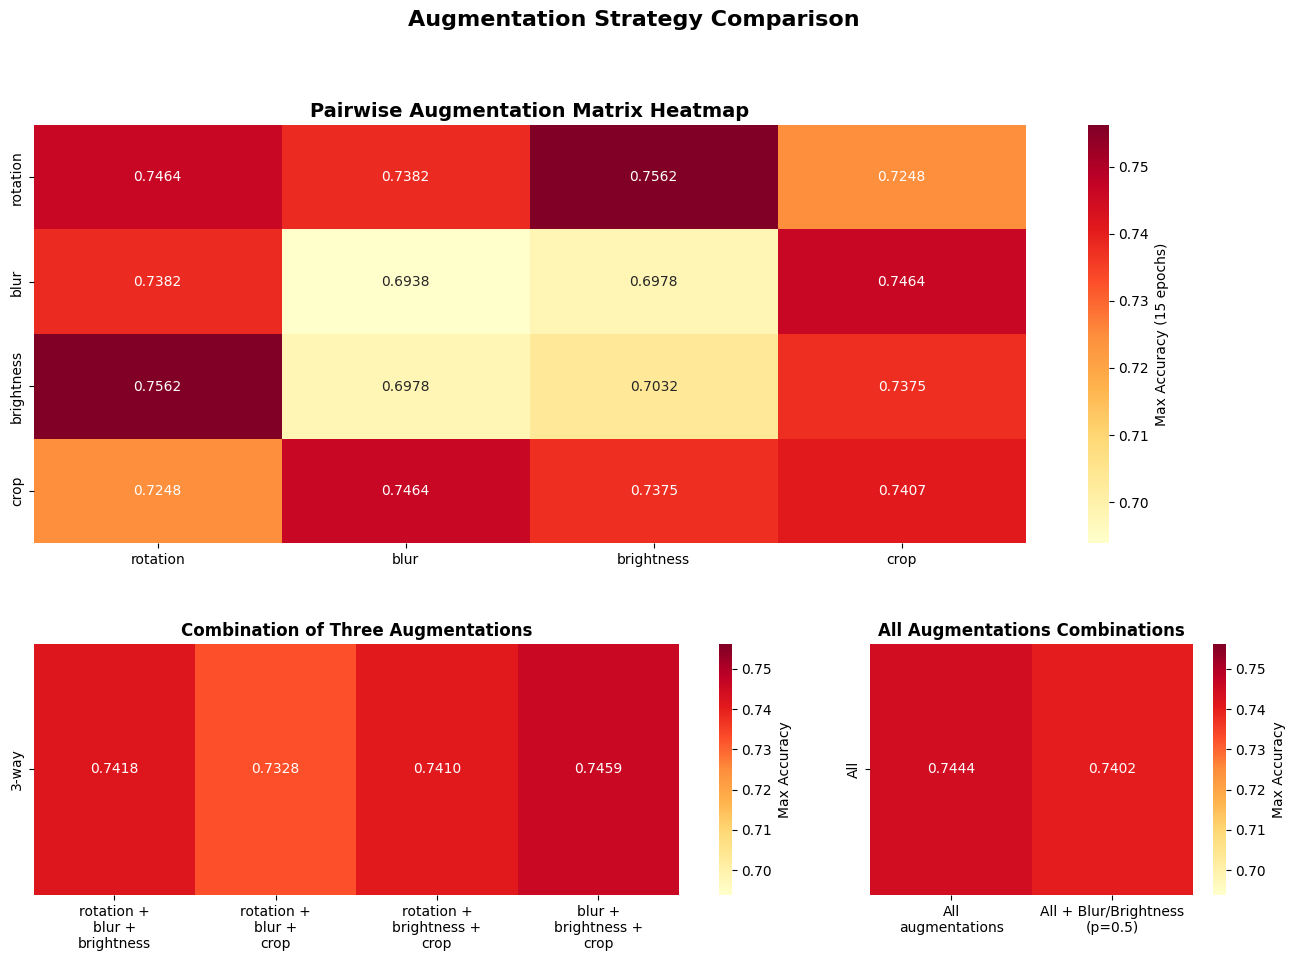

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import numpy as np

augmentations = ["rotation", "blur", "brightness", "crop"]

# Calculate global min and max for consistent color scaling
all_values = []
for row in augmentation_matrix:
    all_values.extend([val for val in row if val is not None])
all_values.extend(additional_augmentations)
all_values.extend(all_augmentations)
vmin = min(all_values)
vmax = max(all_values)

# Create figure with custom grid layout
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 0.6], width_ratios=[1, 0.5], hspace=0.3, wspace=0.05)

# First heatmap: 4x4 augmentation matrix (spans full width on top)
ax1 = fig.add_subplot(gs[0, :])
sns.heatmap(augmentation_matrix, 
            annot=True, 
            fmt='.4f', 
            cmap='YlOrRd',
            xticklabels=augmentations,
            yticklabels=augmentations,
            cbar_kws={'label': 'Max Accuracy (15 epochs)'},
            vmin=vmin,
            vmax=vmax,
            ax=ax1)
ax1.set_title('Pairwise Augmentation Matrix Heatmap', fontsize=14, fontweight='bold')

# Second heatmap: 1x4 for additional augmentations (v1.6.11 to v1.6.14)
ax2 = fig.add_subplot(gs[1, 0])
additional_matrix = [additional_augmentations]
sns.heatmap(additional_matrix,
            annot=True,
            fmt='.4f',
            cmap='YlOrRd',
            xticklabels=['rotation +\nblur +\nbrightness', 'rotation +\nblur +\ncrop', 'rotation +\nbrightness +\ncrop', 'blur +\nbrightness +\ncrop'],
            yticklabels=['3-way'],
            cbar_kws={'label': 'Max Accuracy'},
            vmin=vmin,
            vmax=vmax,
            ax=ax2)
ax2.set_title('Combination of Three Augmentations', fontsize=12, fontweight='bold')
ax2.set_ylabel('')

# Third heatmap: 1x2 for all augmentations (v1.6.15 and v1.6.16)
ax3 = fig.add_subplot(gs[1, 1])
all_matrix = [all_augmentations]
sns.heatmap(all_matrix,
            annot=True,
            fmt='.4f',
            cmap='YlOrRd',
            xticklabels=['All\naugmentations', 'All + Blur/Brightness\n(p=0.5)'],
            yticklabels=['All'],
            cbar_kws={'label': 'Max Accuracy'},
            vmin=vmin,
            vmax=vmax,
            ax=ax3)
ax3.set_title('All Augmentations Combinations', fontsize=12, fontweight='bold')
ax3.set_ylabel('')

plt.suptitle('Augmentation Strategy Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.show()